### Single Factor Analysis

In [1]:
import os
from pathlib import Path


# Change directory
# Modify this cell to insure that the output shows the correct path.
# Define all paths relative to the project root shown in the cell output
project_root = "/Users/liuqiaowei/SourceCode/freqtrade/user_data/notebooks"
i = 0
try:
    os.chdir(project_root)
    if not Path("LICENSE").is_file():
        i = 0
        while i < 4 and (not Path("LICENSE").is_file()):
            os.chdir(Path(Path.cwd(), "../"))
            i += 1
        project_root = Path.cwd()
except FileNotFoundError:
    print("Please define the project root relative to the current directory")
print(Path.cwd())

/Users/liuqiaowei/SourceCode/freqtrade


### Config

In [2]:
from freqtrade.configuration import Configuration


# Customize these according to your needs.

# Initialize empty configuration object
config = Configuration.from_files(["./user_data/config.json"])
# Optionally (recommended), use existing configuration file
# config = Configuration.from_files(["user_data/config.json"])

# Location of the data
data_location = config["datadir"]
config['timeframe'] = '1h'
# Pair to analyze - Only use one pair here
# config['exchange']['pair_whitelist']

### Loading OHLCV Data

In [3]:
from freqtrade.data.history import load_pair_history
from freqtrade.enums import CandleType

candles_dict = {}
for pair in config['exchange']['pair_whitelist']:
    candles = load_pair_history(
        datadir=data_location,
        timeframe=config["timeframe"],
        pair=pair,
        data_format="feather",  # Make sure to update this to your data
        candle_type=CandleType.FUTURES,
    )
    candles_dict[pair] = candles.iloc[:-168]
    # candles_dict[pair] = candles


In [4]:
import datetime

candles_dict['BTC/USDT:USDT'].iloc[-1]['date'].to_pydatetime() + datetime.timedelta(hours=1)

datetime.datetime(2024, 10, 31, 2, 0, tzinfo=datetime.timezone.utc)

### Generate Factor

In [15]:
# Moment
import pandas as pd
import numpy as np
import talib.abstract as ta

def factor_mom_12(dataframe: pd.DataFrame, pair_name: str) -> pd.DataFrame:
        dataframe[pair_name] = (dataframe['close'] - dataframe['close'].shift(12)) / dataframe['close'].shift(12)
        return dataframe

def factor_mom_24(dataframe: pd.DataFrame, pair_name: str) -> pd.DataFrame:
        dataframe[pair_name] = (dataframe['close'] - dataframe['close'].shift(24)) / dataframe['close'].shift(24)
        return dataframe

def factor_adx_34(dataframe: pd.DataFrame, pair_name: str) -> pd.DataFrame:
    dataframe[pair_name] = ta.ADX(dataframe, timeperiod=34)
    return dataframe


def factor_open(dataframe: pd.DataFrame, pair_name: str) -> pd.DataFrame:
    dataframe[pair_name] = dataframe['open']
    return dataframe

def factor_rsi_56(dataframe: pd.DataFrame, pair_name: str) -> pd.DataFrame:
    dataframe[pair_name] = ta.RSI(dataframe, timeperiod=56)
    return dataframe

def factor_rsi_24(dataframe: pd.DataFrame, pair_name: str) -> pd.DataFrame:
    dataframe[pair_name] = ta.RSI(dataframe, timeperiod=24)
    return dataframe

def factor_roc_15(dataframe: pd.DataFrame, pair_name: str) -> pd.DataFrame:
    dataframe[pair_name] = ta.ROC(dataframe, timeperiod=15)
    return dataframe

def factor_cmo_11(dataframe: pd.DataFrame, pair_name: str) -> pd.DataFrame:
    dataframe[pair_name] = ta.CMO(dataframe, timeperiod=11)
    return dataframe

def factor_cci_20(dataframe: pd.DataFrame, pair_name: str) -> pd.DataFrame:
    dataframe[pair_name] = ta.CCI(dataframe, timeperiod=20)
    return dataframe

def factor_mfi_35(dataframe: pd.DataFrame, pair_name: str) -> pd.DataFrame:
    dataframe[pair_name] = ta.MFI(dataframe, timeperiod=35)
    return dataframe

def factor_bop(dataframe: pd.DataFrame, pair_name: str) -> pd.DataFrame:
    dataframe[pair_name] = ta.BOP(dataframe)
    return dataframe

def factor_rocr(dataframe: pd.DataFrame, pair_name: str) -> pd.DataFrame:
    dataframe[pair_name] = ta.ROCR(dataframe, timeperiod=52)
    return dataframe

def factor_HT_TRENDMODE(dataframe: pd.DataFrame, pair_name: str) -> pd.DataFrame:
    dataframe[pair_name] = ta.HT_TRENDMODE(dataframe)
    return dataframe

def factor_natr(dataframe: pd.DataFrame, pair_name: str) -> pd.DataFrame:
    dataframe[pair_name] = ta.NATR(dataframe, timeperiod=12)
    return dataframe


### Construct factor dataframe

In [56]:
factors_df = pd.DataFrame()
open_df = pd.DataFrame()
for key, value in candles_dict.items():
    candles = value.copy()
    candles.set_index(['date'], inplace=True)
    if factors_df.shape[0] == 0:
        factors_df = factor_natr(candles, key)[key].to_frame()
        open_df = factor_open(candles, key)[key].to_frame()
    else:
        factors_df = factors_df.join(factor_natr(candles, key)[key].to_frame())
        open_df = open_df.join(factor_open(candles, key)[key].to_frame())
    
    

In [57]:
factors_df

,BTC/USDT:USDT,ETH/USDT:USDT,BNB/USDT:USDT,XRP/USDT:USDT,ADA/USDT:USDT,DOGE/USDT:USDT,SOL/USDT:USDT,TRX/USDT:USDT,DOT/USDT:USDT,LTC/USDT:USDT,...,BLUR/USDT:USDT,KSM/USDT:USDT,1000FLOKI/USDT:USDT,ICX/USDT:USDT,T/USDT:USDT,LUNA2/USDT:USDT,ZRX/USDT:USDT,SXP/USDT:USDT,ONT/USDT:USDT,PENDLE/USDT:USDT
date,,,,,,,,,,,,,,,,,,,,,
2024-03-17 20:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-03-17 21:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-03-17 22:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-03-17 23:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-03-18 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-30 21:00:00+00:00,0.747836,1.054317,0.594962,0.572762,0.935851,1.713856,1.218081,0.346215,0.951871,0.746529,...,1.564291,1.079609,1.620679,0.985819,0.875030,1.110594,1.317379,1.238475,0.985016,1.738353
2024-10-30 22:00:00+00:00,0.732407,1.025082,0.578505,0.550563,0.920622,1.680074,1.159795,0.338326,0.930601,0.739013,...,1.515721,1.041552,1.583821,0.955365,0.859775,1.134217,1.288872,1.242481,0.954798,1.681284
2024-10-30 23:00:00+00:00,0.713292,0.984901,0.567691,0.536109,0.896022,1.629072,1.131305,0.336121,0.883283,0.724216,...,1.477249,0.988391,1.578415,0.913690,0.821758,1.085260,1.248246,1.215697,0.916058,1.652594


### Standardize Factor

In [58]:
def mad(df, n=3 * 1.4826):
    def filter_extreme_MAD(series, n):
        median = series.median()
        new_median = ((series - median).abs()).median()
        return series.clip(median - n * new_median, median + n * new_median)

    df = df.apply(lambda x: filter_extreme_MAD(x, n), axis=1)
    return df


def standardize(df):
    return df.sub(df.mean(axis=1), axis=0).div(df.std(axis=1), axis=0)

In [59]:
standardize_factor_df = standardize(factors_df)
standardize_factor_df

,BTC/USDT:USDT,ETH/USDT:USDT,BNB/USDT:USDT,XRP/USDT:USDT,ADA/USDT:USDT,DOGE/USDT:USDT,SOL/USDT:USDT,TRX/USDT:USDT,DOT/USDT:USDT,LTC/USDT:USDT,...,BLUR/USDT:USDT,KSM/USDT:USDT,1000FLOKI/USDT:USDT,ICX/USDT:USDT,T/USDT:USDT,LUNA2/USDT:USDT,ZRX/USDT:USDT,SXP/USDT:USDT,ONT/USDT:USDT,PENDLE/USDT:USDT
date,,,,,,,,,,,,,,,,,,,,,
2024-03-17 20:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-03-17 21:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-03-17 22:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-03-17 23:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-03-18 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-30 21:00:00+00:00,-1.221452,-0.440088,-1.611201,-1.667798,-0.742113,1.241386,-0.022577,-2.245374,-0.701271,-1.224784,...,0.860073,-0.375608,1.003834,-0.614722,-0.897175,-0.296612,0.230579,0.029417,-0.616770,1.303841
2024-10-30 22:00:00+00:00,-1.228620,-0.462826,-1.631308,-1.704420,-0.736150,1.250980,-0.110346,-2.259744,-0.710040,-1.211333,...,0.820944,-0.419731,0.999132,-0.645244,-0.895357,-0.177272,0.227389,0.106005,-0.646728,1.254145
2024-10-30 23:00:00+00:00,-1.226132,-0.497455,-1.616753,-1.701482,-0.735901,1.230737,-0.104680,-2.238011,-0.770076,-1.196824,...,0.823424,-0.488093,1.094834,-0.688502,-0.935138,-0.228210,0.209050,0.121729,-0.682146,1.293842


### Do simple IC Check

In [60]:
def Quick_Factor_Return_N_IC(factor_df: pd.DataFrame, open_df: pd.DataFrame, n: int, name='', time_frame=''):
    return_n = open_df.pct_change(n).shift(-n - 1)
    result = factor_df.corrwith(return_n, axis=1, method='spearman').dropna(how='all')
    report = {
        'name': name,
        'time frame': time_frame,
        'IC mean': round(result.mean(), 4),
        'IC std': round(result.std(), 4),
        'IR': round(result.mean() / result.std(), 4),
        'IC>0': round(len(result[result > 0].dropna()) / len(result), 4),
        'ABS_IC>2%': round(len(result[abs(result) > 0.02].dropna()) / len(result), 4),
    }
    return result, report

In [61]:
target_n = 4

ic_result, report = Quick_Factor_Return_N_IC(standardize_factor_df, open_df, target_n, 'moment_24', '1h')

/var/folders/r4/37x1j92s4dv970k2bn0sv0840000gn/T/ipykernel_67218/2660244081.py:2: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  return_n = open_df.pct_change(n).shift(-n - 1)


In [62]:
report['']

KeyError: ''

<Axes: title={'center': 'CUM_IC'}, xlabel='date'>

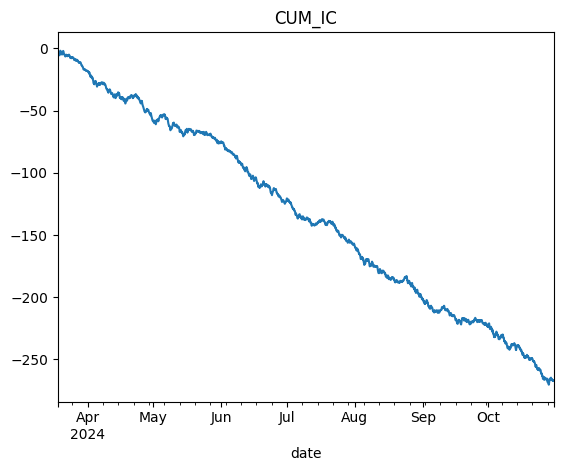

In [63]:
import matplotlib.pyplot as plt

ic_result.cumsum().plot(title = 'CUM_IC')

<Axes: title={'center': 'IC_DAILY'}, xlabel='date'>

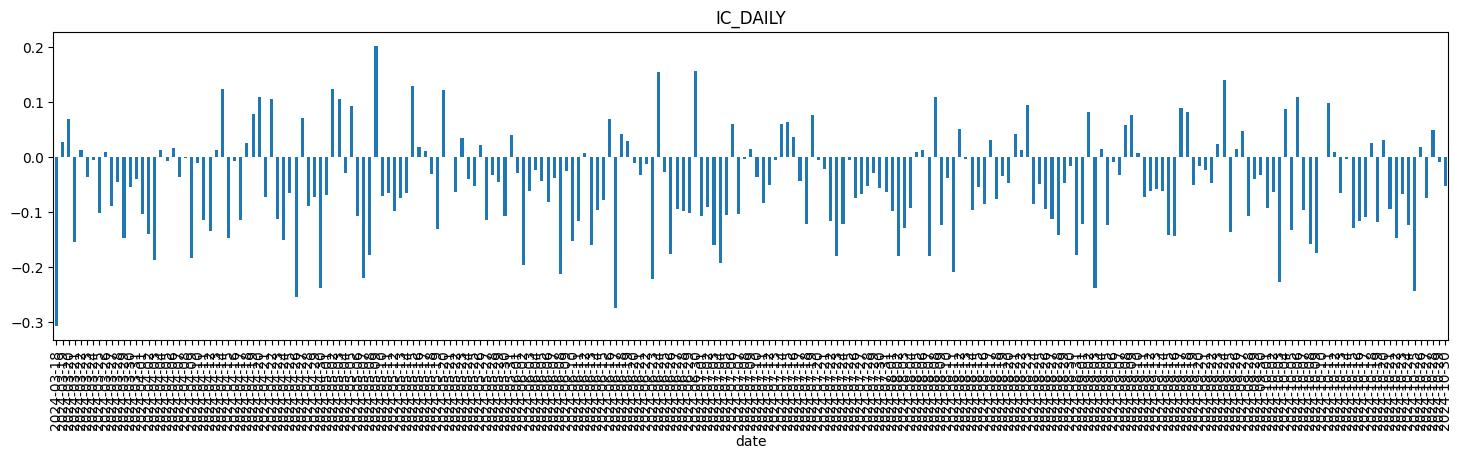

In [64]:
ic_day = ic_result.resample('D').mean()
ic_day.index = ic_day.index.strftime("%F")
ic_day.plot(kind = 'bar',figsize=(18,4),title = 'IC_DAILY')

In [65]:
if report['IC mean'] < 0:
    standardize_factor_df = standardize_factor_df * -1

### Group Analysis

In [66]:
pair_list = factors_df.columns.to_list()
change_position_period = 4
group_count = 10
return_df = open_df.pct_change().shift(-2).dropna(how='all', axis=0).stack()

# if report['IC mean'] < 0:
#     standardize_factor_df = standardize_factor_df * -1

group_df = standardize_factor_df.stack().to_frame('factor')
group_df['current_return'] = return_df

/var/folders/r4/37x1j92s4dv970k2bn0sv0840000gn/T/ipykernel_67218/4133179004.py:4: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  return_df = open_df.pct_change().shift(-2).dropna(how='all', axis=0).stack()


In [67]:
group_df.reset_index(inplace=True)
group_df.columns = ['date', 'pair', 'factor', 'current_return']
group_df

,date,pair,factor,current_return
0,2024-03-18 08:00:00+00:00,BTC/USDT:USDT,1.599324,-0.002752
1,2024-03-18 08:00:00+00:00,ETH/USDT:USDT,1.481837,-0.009718
2,2024-03-18 08:00:00+00:00,BNB/USDT:USDT,-0.109216,-0.014309
3,2024-03-18 08:00:00+00:00,XRP/USDT:USDT,1.284074,-0.008773
4,2024-03-18 08:00:00+00:00,ADA/USDT:USDT,0.062895,-0.010262
...,...,...,...,...
549254,2024-10-31 01:00:00+00:00,LUNA2/USDT:USDT,0.199654,NaN
549255,2024-10-31 01:00:00+00:00,ZRX/USDT:USDT,-0.311482,NaN
549256,2024-10-31 01:00:00+00:00,SXP/USDT:USDT,-0.637743,NaN
549257,2024-10-31 01:00:00+00:00,ONT/USDT:USDT,0.640481,NaN


In [68]:
datetime_period = sorted(group_df.date.drop_duplicates().tolist())
turnover_ratio = pd.DataFrame()
group_return = pd.DataFrame()

for i in range(0, len(datetime_period)-1, change_position_period):
    single = group_df[group_df['date'] == datetime_period[i]].sort_values(by='factor')
    single.loc[:,'group'] = pd.qcut(single.factor, group_count, list(range(1, group_count+1))).to_list()
    group_dict = {}
    for j in range(1, group_count+1):
        group_dict[j] = single[single.group == j].pair.to_list()
        
    turnover_ratio_temp = []
    if i == 0:
        temp_group_dict = group_dict
    else:
        for j in range(1,group_count+1):
            turnover_ratio_temp.append(len(list(set(temp_group_dict[j]).difference(set(group_dict[j]))))/len(set(temp_group_dict[j])))
        turnover_ratio = pd.concat([turnover_ratio,
                                        pd.DataFrame(turnover_ratio_temp,
                                                    index = ['G{}'.format(j) for j in list(range(1,group_count+1))],
                                                    columns = [datetime_period[i]]).T],
                                                    axis = 0)
        temp_group_dict = group_dict
        
    if i < len(datetime_period) - change_position_period:
        period = group_df[group_df.date.isin(datetime_period[i:i+change_position_period])]
    else:
        period = group_df[group_df.date.isin(datetime_period[i:])]
    
    group_return_temp = []
    for j in range(1, group_count+1):
        group_return_temp.append(period[period.pair.isin(group_dict[j])].set_index(['date','pair']).current_return.unstack('pair').mean(axis = 1))
    group_return = pd.concat([group_return,pd.DataFrame(group_return_temp,index = ['G{}'.format(j) for j in list(range(1,group_count+1))]).T],axis = 0)
    print('\r 当前：{} / 总量：{}'.format(i,len(datetime_period)),end='')
    
group_return

 当前：5440 / 总量：5442

,G1,G2,G3,G4,G5,G6,G7,G8,G9,G10
date,,,,,,,,,,
2024-03-18 08:00:00+00:00,-0.014906,-0.008303,-0.012894,-0.015636,-0.015706,-0.013242,-0.011950,-0.013559,-0.011575,-0.008059
2024-03-18 09:00:00+00:00,0.006192,0.008671,0.009861,0.013598,0.014315,0.014960,0.011314,0.009758,0.011660,0.006983
2024-03-18 10:00:00+00:00,0.003920,-0.002783,-0.000580,-0.001738,0.001077,0.000205,0.000126,0.002312,0.000750,0.000919
2024-03-18 11:00:00+00:00,-0.002686,0.000128,0.000505,0.004876,0.005430,-0.002072,-0.001478,0.000665,0.001373,0.000492
2024-03-18 12:00:00+00:00,-0.025537,-0.025947,-0.024992,-0.022145,-0.023646,-0.027801,-0.025760,-0.025467,-0.022138,-0.017024
...,...,...,...,...,...,...,...,...,...,...
2024-10-30 21:00:00+00:00,-0.000512,0.000870,-0.005272,-0.001648,0.001852,0.000526,-0.000344,-0.001113,-0.001985,-0.001189
2024-10-30 22:00:00+00:00,-0.000101,-0.003219,-0.002206,-0.001102,-0.002965,-0.001408,-0.000489,-0.000808,-0.000825,-0.000927
2024-10-30 23:00:00+00:00,-0.005355,-0.003699,-0.003155,-0.005321,-0.005066,-0.005095,-0.004739,-0.001904,-0.001946,-0.002307


In [52]:
group_return.dropna(how='all', axis=0, inplace=True)
group_return['Benchmark'] = group_return.mean(axis = 1)
group_return = (group_return+1).cumprod()
group_return

,G1,G2,G3,G4,G5,G6,G7,G8,G9,G10,Benchmark
date,,,,,,,,,,,
2024-03-18 15:00:00+00:00,0.990148,0.989584,0.983315,0.988210,0.986366,0.987197,0.987850,0.987902,0.990458,0.992038,0.988307
2024-03-18 16:00:00+00:00,0.982301,0.983710,0.981848,0.986529,0.989129,0.984564,0.985830,0.987113,0.989938,0.990840,0.986182
2024-03-18 17:00:00+00:00,0.968341,0.976666,0.974436,0.978277,0.977277,0.973383,0.975507,0.977030,0.981067,0.980972,0.976298
2024-03-18 18:00:00+00:00,0.974661,0.979015,0.977772,0.977954,0.977588,0.977152,0.976959,0.978455,0.983401,0.984047,0.978707
2024-03-18 19:00:00+00:00,0.977844,0.990741,0.986783,0.988837,0.988014,0.988784,0.988246,0.991201,0.996001,0.993872,0.989035
...,...,...,...,...,...,...,...,...,...,...,...
2024-10-30 19:00:00+00:00,0.321009,0.690471,0.711194,0.472947,0.659058,0.670825,0.665674,0.657151,0.778276,0.766144,0.627702
2024-10-30 20:00:00+00:00,0.318918,0.684703,0.704875,0.469718,0.655045,0.666596,0.661669,0.653163,0.772717,0.762458,0.623495
2024-10-30 21:00:00+00:00,0.317621,0.684379,0.704014,0.469553,0.655307,0.666105,0.661943,0.652220,0.773475,0.760692,0.622946


In [53]:
group_weekly_ret = (group_return.iloc[-1] ** (24 * 7/len(group_return)) - 1)
group_weekly_ret -= group_weekly_ret.Benchmark
group_weekly_ret = group_weekly_ret.drop('Benchmark').to_frame('weekly_ret')
group_weekly_ret['group'] = list(range(1, group_count+1))
group_weekly_ret

,weekly_ret,group
G1,-0.020346,1
G2,0.002835,2
G3,0.003775,3
G4,-0.008628,4
G5,0.001598,5
G6,0.002110,6
G7,0.001812,7
G8,0.001395,8
G9,0.006595,9
G10,0.006133,10


<Axes: title={'center': 'Factor_Monotony0.4788'}>

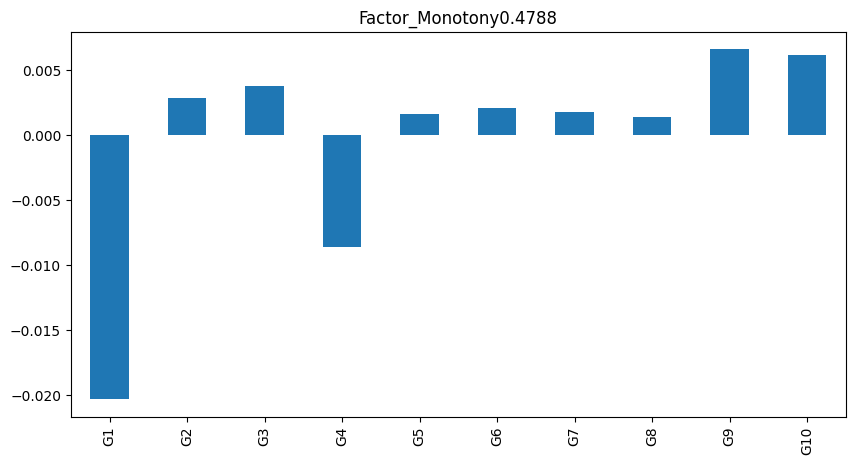

In [54]:
corr_value = round(group_weekly_ret.corr(method = 'spearman').iloc[0,1],4)
group_weekly_ret.weekly_ret.plot(kind='bar', figsize=(10, 5), title = f'Factor_Monotony{corr_value}')

<Axes: title={'center': 'Factor_Group'}, xlabel='date'>

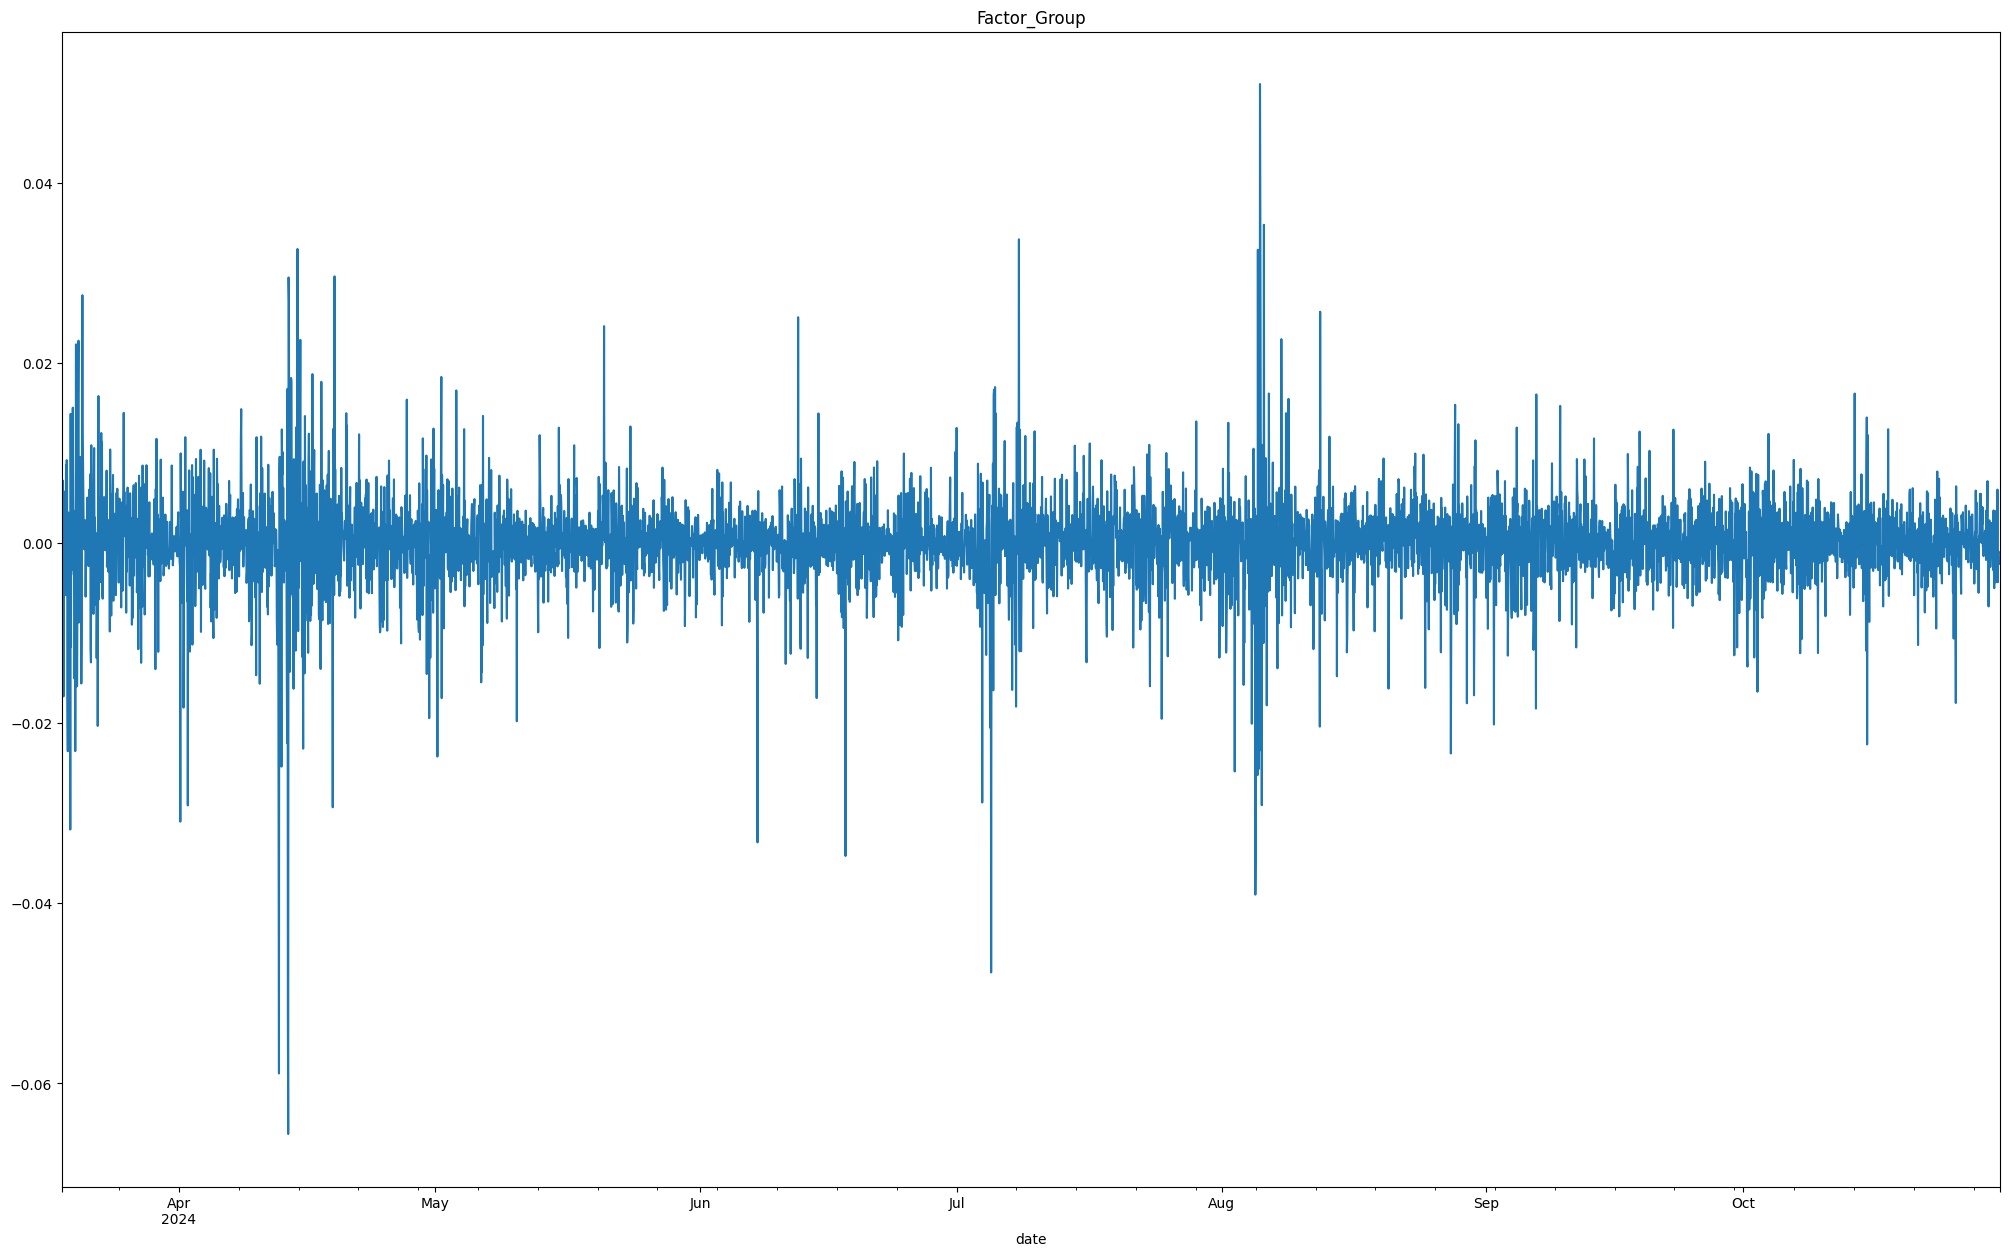

In [69]:
group_return['G10'].plot(figsize=(25, 15), title = f'Factor_Group')